### Telco Customer Churn Classification Project - rough draft

In [1]:
# bring in my imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from env import host, user, password


import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

# Plan -> Acquire -> Prepare -> Explore -> Model & Evaluate -> Deliver

## Acquire my data

In [2]:
def get_db_url(host, user, password, database):
    url = f'mysql+pymysql://{user}:{password}@{host}/{database}'
    return url

In [3]:
url = get_db_url(host, user, password, 'telco_churn')

In [4]:
pd.read_sql('SELECT * FROM customers LIMIT 5 OFFSET 50', url)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0083-PIVIK,Male,0,No,No,64,Yes,Yes,1,Yes,...,Yes,Yes,Yes,No,2,No,1,81.25,5567.55,No
1,0089-IIQKO,Female,0,Yes,Yes,39,Yes,Yes,2,No,...,No,Yes,Yes,Yes,1,Yes,4,99.95,3767.4,No
2,0093-EXYQL,Female,1,No,No,40,Yes,No,2,No,...,No,No,Yes,Yes,1,Yes,1,91.55,3673.6,No
3,0093-XWZFY,Male,0,No,No,40,Yes,Yes,2,No,...,Yes,No,Yes,Yes,1,Yes,4,104.50,4036.85,Yes
4,0094-OIFMO,Female,1,No,No,11,Yes,No,2,No,...,No,No,Yes,Yes,1,Yes,1,95.00,1120.3,Yes


In [5]:
pd.read_sql(
'''
SELECT *
FROM payment_types
JOIN customers ON payment_types.payment_type_id = customers.payment_type_id
JOIN internet_service_types ON internet_service_types.internet_service_type_id = customers.internet_service_type_id
JOIN contract_types ON contract_types.contract_type_id = customers.contract_type_id;
''', url
)

,payment_type_id,payment_type,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,internet_service_type_id,internet_service_type,contract_type_id,contract_type
0,2,Mailed check,0030-FNXPP,Female,0,No,No,3,Yes,No,...,1,No,2,19.85,57.2,No,3,None,1,Month-to-month
1,2,Mailed check,0031-PVLZI,Female,0,Yes,Yes,4,Yes,No,...,1,No,2,20.35,76.35,Yes,3,None,1,Month-to-month
2,1,Electronic check,0098-BOWSO,Male,0,No,No,27,Yes,No,...,1,Yes,1,19.40,529.8,No,3,None,1,Month-to-month
3,1,Electronic check,0107-WESLM,Male,0,No,No,1,Yes,No,...,1,Yes,1,19.85,19.85,Yes,3,None,1,Month-to-month
4,3,Bank transfer (automatic),0114-RSRRW,Female,0,Yes,No,10,Yes,No,...,1,Yes,3,19.95,187.75,No,3,None,1,Month-to-month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4,Credit card (automatic),9919-FZDED,Male,1,Yes,No,72,Yes,Yes,...,3,Yes,4,84.10,5981.65,No,1,DSL,3,Two year
7039,3,Bank transfer (automatic),9926-PJHDQ,Female,0,Yes,Yes,72,Yes,Yes,...,3,Yes,3,76.80,5468.45,No,1,DSL,3,Two year
7040,2,Mailed check,9928-BZVLZ,Female,0,No,No,12,No,No phone service,...,3,No,2,49.85,552.1,No,1,DSL,3,Two year
7041,2,Mailed check,9993-LHIEB,Male,0,Yes,Yes,67,Yes,No,...,3,No,2,67.85,4627.65,No,1,DSL,3,Two year


In [6]:
# now we've done everything manually, let's combine and create functions
# create helper function
def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the sql database.
    '''
    from env import host, user, password
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [7]:
# create my function for my sql query
def get_new_telco_churn_data():
    '''
    This function reads in the telco churn data from the sql database
    and returns a pandas DataFrame with all columns.
    '''
    sql_query = '''
    SELECT *
    FROM payment_types
    JOIN customers ON payment_types.payment_type_id = customers.payment_type_id
    JOIN internet_service_types ON internet_service_types.internet_service_type_id = customers.internet_service_type_id
    JOIN contract_types ON contract_types.contract_type_id = customers.contract_type_id;
    '''
    return pd.read_sql(sql_query, get_connection('telco_churn'))

In [8]:
df = get_new_telco_churn_data()

In [9]:
df.sample(5)

,payment_type_id,payment_type,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,internet_service_type_id,internet_service_type,contract_type_id,contract_type
1426,1,Electronic check,4191-XOVOM,Male,0,No,No,63,Yes,Yes,...,1,No,1,105.40,6713.2,No,2,Fiber optic,1,Month-to-month
106,2,Mailed check,2002-MZHWP,Female,0,No,No,1,Yes,No,...,1,No,2,20.50,20.5,Yes,3,None,1,Month-to-month
2760,1,Electronic check,0991-BRRFB,Male,0,No,No,18,Yes,No,...,1,No,1,49.40,874.8,Yes,1,DSL,1,Month-to-month
6182,3,Bank transfer (automatic),4822-LPTYJ,Male,0,Yes,No,72,Yes,Yes,...,3,Yes,3,103.75,7346.2,No,2,Fiber optic,3,Two year
2216,1,Electronic check,7851-WZEKY,Female,0,No,No,2,Yes,Yes,...,1,Yes,1,95.15,196.9,Yes,2,Fiber optic,1,Month-to-month


In [10]:
df.shape

(7043, 27)

In [11]:
# make sure our function works
df = acquire.get_new_telco_churn_data()

In [12]:
df.sample(5)

,payment_type_id,payment_type,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,internet_service_type_id,internet_service_type,contract_type_id,contract_type
6464,4,Credit card (automatic),0739-UUAJR,Female,0,Yes,Yes,72,No,No phone service,...,3,Yes,4,53.80,3952.45,No,1,DSL,3,Two year
5790,3,Bank transfer (automatic),6961-MJKBO,Male,0,No,No,47,Yes,No,...,3,No,3,20.45,943,No,3,None,3,Two year
5457,2,Mailed check,1709-EJDOX,Female,0,Yes,Yes,47,Yes,No,...,3,No,2,19.75,948.9,No,3,None,3,Two year
1040,1,Electronic check,2506-TNFCO,Female,1,Yes,No,1,Yes,No,...,1,Yes,1,69.55,69.55,Yes,2,Fiber optic,1,Month-to-month
6097,4,Credit card (automatic),2599-CIPQE,Male,0,Yes,Yes,71,Yes,No,...,3,No,4,109.30,7782.85,No,2,Fiber optic,3,Two year


In [13]:
df.info

<bound method DataFrame.info of      payment_type_id               payment_type customer_id  gender  \
0                  2               Mailed check  0030-FNXPP  Female   
1                  2               Mailed check  0031-PVLZI  Female   
2                  1           Electronic check  0098-BOWSO    Male   
3                  1           Electronic check  0107-WESLM    Male   
4                  3  Bank transfer (automatic)  0114-RSRRW  Female   
...              ...                        ...         ...     ...   
7038               4    Credit card (automatic)  9919-FZDED    Male   
7039               3  Bank transfer (automatic)  9926-PJHDQ  Female   
7040               2               Mailed check  9928-BZVLZ  Female   
7041               2               Mailed check  9993-LHIEB    Male   
7042               1           Electronic check  9995-HOTOH    Male   

      senior_citizen partner dependents  tenure phone_service  \
0                  0      No         No       3   

## Prepare my data

In [14]:
list(df.columns)

['payment_type_id',
 'payment_type',
 'customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'internet_service_type_id',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract_type_id',
 'paperless_billing',
 'payment_type_id',
 'monthly_charges',
 'total_charges',
 'churn',
 'internet_service_type_id',
 'internet_service_type',
 'contract_type_id',
 'contract_type']

In [15]:
# how to rid of duplicate column
df = df.loc[:, ~df.columns.duplicated()]

In [16]:
df.shape

(7043, 24)

In [17]:
df.sample(5)

,payment_type_id,payment_type,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type
1024,4,Credit card (automatic),2452-SNHFZ,Female,0,No,No,47,Yes,No,...,No,No,No,1,No,75.45,3545.1,No,Fiber optic,Month-to-month
4266,4,Credit card (automatic),0512-FLFDW,Female,1,Yes,No,60,Yes,Yes,...,No,Yes,Yes,2,Yes,100.50,6029,No,Fiber optic,One year
6554,3,Bank transfer (automatic),2351-BKRZW,Female,0,Yes,Yes,43,Yes,No,...,No,Yes,Yes,3,No,75.20,3254.35,No,DSL,Two year
4169,2,Mailed check,8076-FEZKJ,Male,0,No,No,10,Yes,No,...,No internet service,No internet service,No internet service,2,No,19.50,225.85,No,None,One year
4309,1,Electronic check,1229-RCALF,Female,0,Yes,No,64,Yes,Yes,...,Yes,Yes,Yes,2,Yes,115.00,7396.15,No,Fiber optic,One year


In [18]:
# check for nulls
df.isnull().any()

payment_type_id             False
payment_type                False
customer_id                 False
gender                      False
senior_citizen              False
partner                     False
dependents                  False
tenure                      False
phone_service               False
multiple_lines              False
internet_service_type_id    False
online_security             False
online_backup               False
device_protection           False
tech_support                False
streaming_tv                False
streaming_movies            False
contract_type_id            False
paperless_billing           False
monthly_charges             False
total_charges               False
churn                       False
internet_service_type       False
contract_type               False
dtype: bool

In [19]:
df.dtypes

payment_type_id               int64
payment_type                 object
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
internet_service_type_id      int64
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
contract_type_id              int64
paperless_billing            object
monthly_charges             float64
total_charges                object
churn                        object
internet_service_type        object
contract_type                object
dtype: object

In [20]:
(df['monthly_charges']==0).any()

False

In [21]:
df.monthly_charges.isnull().sum()

0

In [22]:
# telco_df = telco_df['total_charges'].replace('  ', np.nan)

In [23]:
# general value counts on my entire data frame

columns = ['payment_type_id', 'payment_type', 'gender', 'senior_citizen', 'partner', 'dependents', 
           'tenure', 'phone_service', 'multiple_lines', 'internet_service_type_id', 
           'online_security', 'online_backup', 'device_protection', 'tech_support',
          'streaming_tv', 'streaming_movies', 'contract_type_id', 'paperless_billing',
          'monthly_charges', 'total_charges', 'churn', 'internet_service_type', 'contract_type']

for col in columns:
    print(col)
    print(df[col].value_counts())
    print('-------------')

payment_type_id
1    2365
2    1612
3    1544
4    1522
Name: payment_type_id, dtype: int64
-------------
payment_type
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64
-------------
gender
Male      3555
Female    3488
Name: gender, dtype: int64
-------------
senior_citizen
0    5901
1    1142
Name: senior_citizen, dtype: int64
-------------
partner
No     3641
Yes    3402
Name: partner, dtype: int64
-------------
dependents
No     4933
Yes    2110
Name: dependents, dtype: int64
-------------
tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64
-------------
phone_service
Yes    6361
No      682
Name: phone_service, dtype: int64
-------------
multiple_lines
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
-

In [24]:
# make a df just for churned customers so we can hone in on a drive
churned_df = df[df['churn']=='Yes']
churned_df.sample(5)

,payment_type_id,payment_type,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type
1365,1,Electronic check,3908-BLSYF,Female,0,No,No,6,Yes,No,...,No,No,Yes,1,No,83.90,497.55,Yes,Fiber optic,Month-to-month
1068,1,Electronic check,2656-TABEH,Male,0,Yes,No,4,Yes,Yes,...,No,Yes,Yes,1,Yes,100.20,420.2,Yes,Fiber optic,Month-to-month
216,2,Mailed check,3900-AQPHZ,Female,0,No,No,1,Yes,No,...,No internet service,No internet service,No internet service,1,No,19.90,19.9,Yes,None,Month-to-month
2536,3,Bank transfer (automatic),9507-EXLTT,Female,0,Yes,No,1,Yes,No,...,No,Yes,No,1,Yes,79.35,79.35,Yes,Fiber optic,Month-to-month
1598,1,Electronic check,4952-YSOGZ,Female,0,Yes,Yes,4,Yes,Yes,...,No,No,Yes,1,Yes,85.95,381.3,Yes,Fiber optic,Month-to-month


In [25]:
# value counts on my churned data frame

columns = ['payment_type_id', 'payment_type', 'gender', 'senior_citizen', 'partner', 'dependents', 
           'tenure', 'phone_service', 'multiple_lines', 'internet_service_type_id', 
           'online_security', 'online_backup', 'device_protection', 'tech_support',
          'streaming_tv', 'streaming_movies', 'contract_type_id', 'paperless_billing',
          'monthly_charges', 'total_charges', 'churn', 'internet_service_type', 'contract_type']

for col in columns:
    print(col)
    print(churned_df[col].value_counts())
    print('-------------')

payment_type_id
1    1071
2     308
3     258
4     232
Name: payment_type_id, dtype: int64
-------------
payment_type
Electronic check             1071
Mailed check                  308
Bank transfer (automatic)     258
Credit card (automatic)       232
Name: payment_type, dtype: int64
-------------
gender
Female    939
Male      930
Name: gender, dtype: int64
-------------
senior_citizen
0    1393
1     476
Name: senior_citizen, dtype: int64
-------------
partner
No     1200
Yes     669
Name: partner, dtype: int64
-------------
dependents
No     1543
Yes     326
Name: dependents, dtype: int64
-------------
tenure
1     380
2     123
3      94
4      83
5      64
     ... 
45      6
72      6
62      5
63      4
64      4
Name: tenure, Length: 72, dtype: int64
-------------
phone_service
Yes    1699
No      170
Name: phone_service, dtype: int64
-------------
multiple_lines
Yes                 850
No                  849
No phone service    170
Name: multiple_lines, dtype: int64
------

### What are my takeaways?
- Right off the bat I can see which columns have an obvious association to churn:
 - contract_type/contract_type_id
 - internet_service_type/internet_service_type_id
 - paperless billing
 - tech_support
 - device_protection
 - online_backup
 - online security
 - phone_service
 - dependents
 - partner
 - senior_citizen
 - payment_type/paymnent_type_id
 
----------------
 
- Things to investigate further:
 - Is there an association with total charges?
 - Is there an association with monthly charges?
 - Is there an association with tenure?
 
----------------
 
- We don't care too much about:
 - streaming_movies
 - streaming_tv
 - multiple_lines
 - gender

In [26]:
df.sample(5)

,payment_type_id,payment_type,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type
5392,2,Mailed check,0754-EEBDC,Male,0,Yes,Yes,4,Yes,No,...,No internet service,No internet service,No internet service,3,No,19.9,76.65,No,None,Two year
1281,1,Electronic check,3496-LFSZU,Male,0,Yes,No,4,Yes,No,...,No,No,No,1,No,70.5,294.2,No,Fiber optic,Month-to-month
478,2,Mailed check,9063-ZGTUY,Female,0,Yes,Yes,61,Yes,No,...,No internet service,No internet service,No internet service,1,Yes,19.4,1182.55,Yes,None,Month-to-month
1350,4,Credit card (automatic),3838-OZURD,Male,0,Yes,No,66,Yes,Yes,...,No,Yes,Yes,1,Yes,105.0,7133.25,Yes,Fiber optic,Month-to-month
559,1,Electronic check,0178-SZBHO,Male,0,Yes,Yes,47,Yes,Yes,...,No,Yes,No,1,No,87.2,4017.45,No,Fiber optic,Month-to-month


In [27]:
df.dtypes

payment_type_id               int64
payment_type                 object
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
internet_service_type_id      int64
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
contract_type_id              int64
paperless_billing            object
monthly_charges             float64
total_charges                object
churn                        object
internet_service_type        object
contract_type                object
dtype: object

In [28]:
#  Is there an association with monthly charges?
df.monthly_charges.mean(), churned_df.monthly_charges.mean()

(64.76169246059905, 74.44133226324224)

Text(0, 0.5, 'amount of customers')

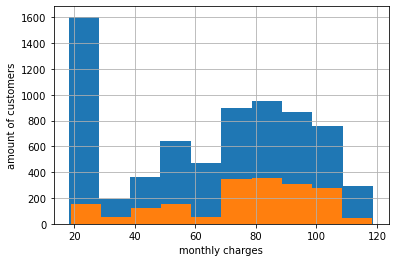

In [36]:
# churned customers pay more monthly charges than overall customers
df.monthly_charges.hist()
churned_df.monthly_charges.hist()
plt.xlabel('monthly charges')
plt.ylabel('amount of customers')

Text(0, 0.5, 'amount of customers')

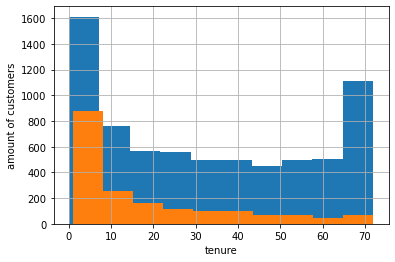

In [39]:
# comparison of tenure
df.tenure.hist()
churned_df.tenure.hist()
plt.xlabel('tenure')
plt.ylabel('amount of customers')

In [30]:
df.columns

Index(['payment_type_id', 'payment_type', 'customer_id', 'gender',
       'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service',
       'multiple_lines', 'internet_service_type_id', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'contract_type_id', 'paperless_billing',
       'monthly_charges', 'total_charges', 'churn', 'internet_service_type',
       'contract_type'],
      dtype='object')

In [31]:
df.sample(10)

,payment_type_id,payment_type,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type
1818,1,Electronic check,5937-EORGB,Male,1,Yes,No,15,Yes,Yes,...,No,Yes,No,1,Yes,96.50,1392.25,No,Fiber optic,Month-to-month
1127,2,Mailed check,2868-SNELZ,Female,0,No,No,2,Yes,Yes,...,No,No,No,1,No,80.60,155.8,Yes,Fiber optic,Month-to-month
81,4,Credit card (automatic),1552-TKMXS,Female,0,Yes,No,42,Yes,No,...,No internet service,No internet service,No internet service,1,No,20.35,869.9,No,None,Month-to-month
6512,4,Credit card (automatic),1775-KWJKQ,Male,0,Yes,Yes,72,Yes,Yes,...,Yes,Yes,Yes,3,No,89.85,6562.9,No,DSL,Two year
5129,1,Electronic check,6253-WRFHY,Male,0,Yes,Yes,13,Yes,No,...,No,Yes,Yes,2,Yes,64.75,877.35,No,DSL,One year
741,1,Electronic check,1013-QCWAM,Female,1,Yes,No,66,Yes,Yes,...,No,Yes,Yes,1,Yes,100.80,6690.75,No,Fiber optic,Month-to-month
6374,4,Credit card (automatic),9053-JZFKV,Male,0,No,No,67,Yes,Yes,...,Yes,Yes,Yes,3,No,116.20,7752.3,Yes,Fiber optic,Two year
4438,2,Mailed check,3642-GKTCT,Female,0,No,No,61,Yes,Yes,...,Yes,Yes,Yes,2,Yes,115.10,6993.65,No,Fiber optic,One year
6466,4,Credit card (automatic),0757-WCUUZ,Male,0,Yes,Yes,54,Yes,Yes,...,No,No,Yes,3,No,63.35,3409.1,No,DSL,Two year
4014,4,Credit card (automatic),4116-IQRFR,Male,0,Yes,Yes,4,Yes,Yes,...,No internet service,No internet service,No internet service,2,No,24.10,73.1,No,None,One year


In [32]:
columns = ['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 
           'online_security', 'online_backup', 'device_protection', 'tech_support',
          'streaming_tv', 'streaming_movies', 'paperless_billing']

for cols in columns:
    df[cols] = np.where(df[cols] == ('Yes' or 'Female'), 1, 0)

In [33]:
df.dtypes

payment_type_id               int64
payment_type                 object
customer_id                  object
gender                        int64
senior_citizen                int64
partner                       int64
dependents                    int64
tenure                        int64
phone_service                 int64
multiple_lines                int64
internet_service_type_id      int64
online_security               int64
online_backup                 int64
device_protection             int64
tech_support                  int64
streaming_tv                  int64
streaming_movies              int64
contract_type_id              int64
paperless_billing             int64
monthly_charges             float64
total_charges                object
churn                        object
internet_service_type        object
contract_type                object
dtype: object

In [ ]:
df = df.drop(columns=['payment_type', 'customer_id', 'internet_service_type', 'contract_type'])

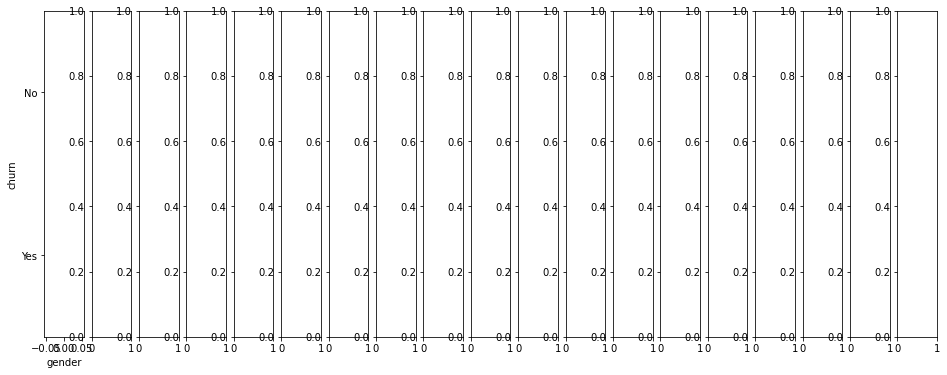

In [34]:
_, ax = plt.subplots(nrows=1, ncols=19, figsize=(16, 6))
for i, column in enumerate(columns):
    sns.barplot(column, 'churn', data=df, ax=ax[i], alpha=0.5)
    plt.show()

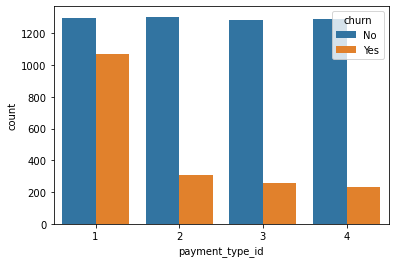

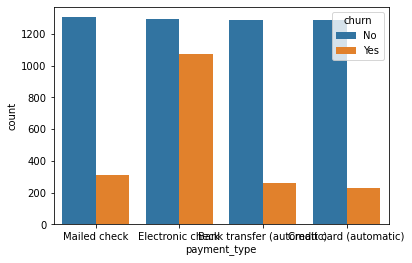

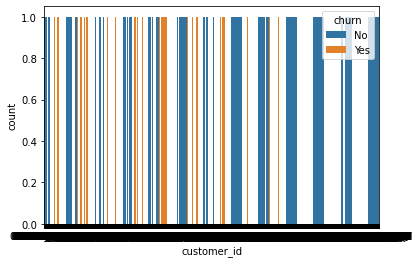

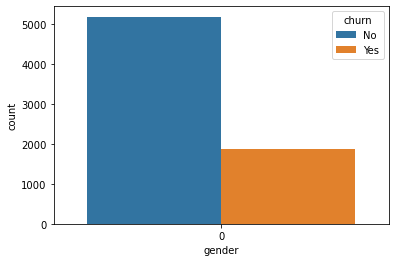

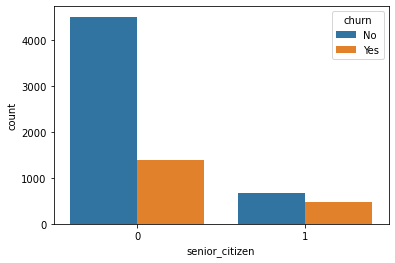

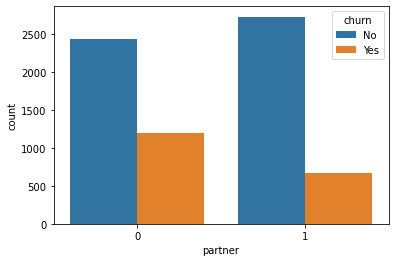

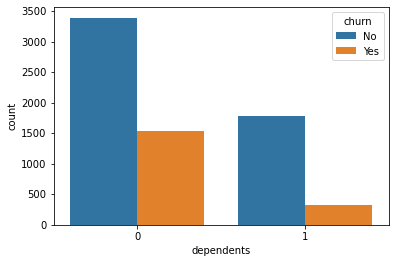

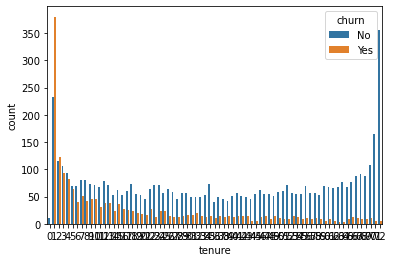

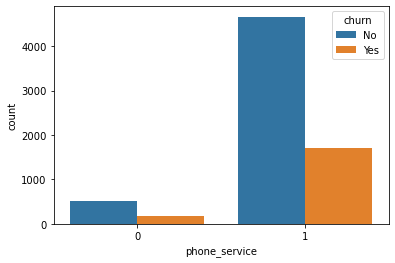

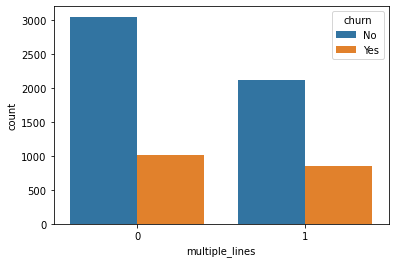

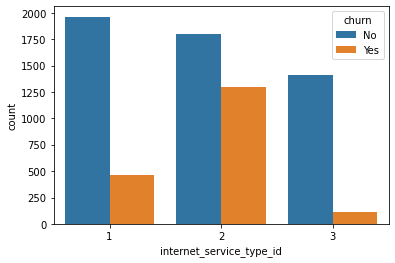

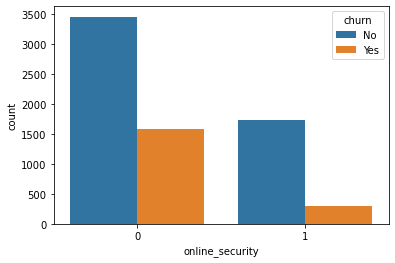

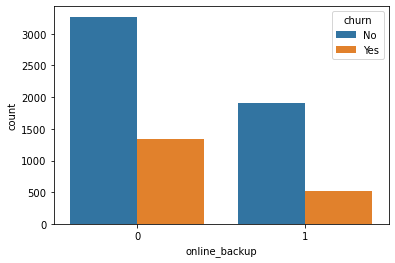

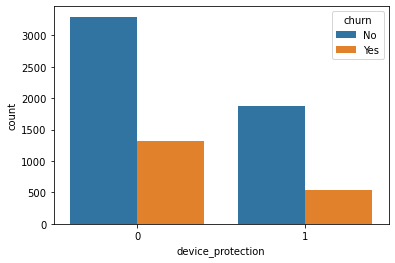

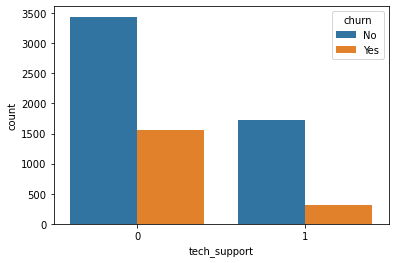

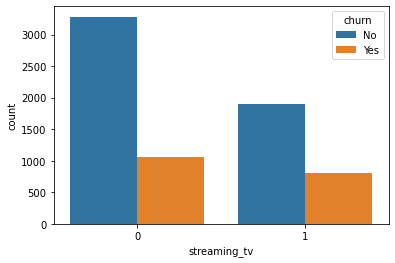

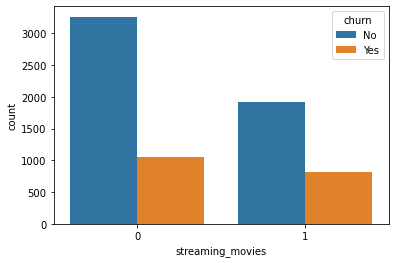

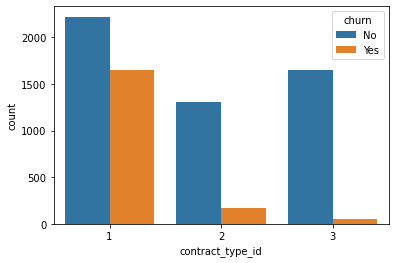

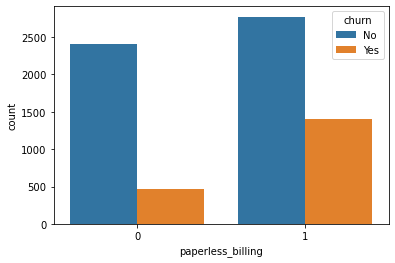

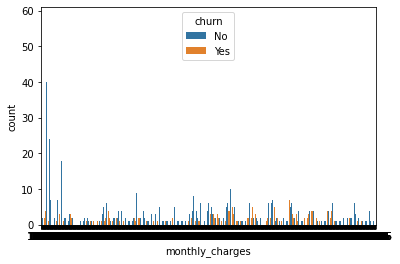

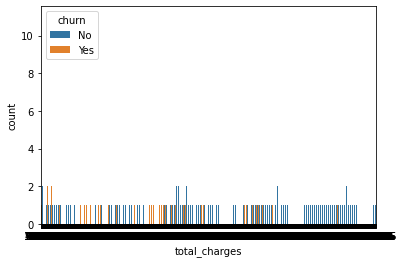

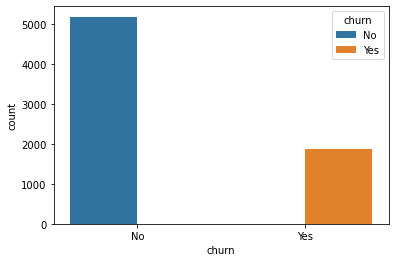

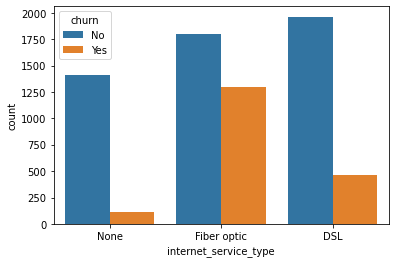

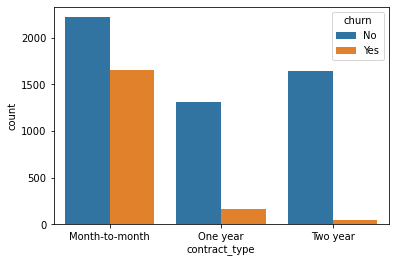

In [35]:
churned_df = df[df['churn']=='Yes']
for i in df.columns:
    sns.countplot(data=df, x=i, hue='churn')
    plt.show()

In [ ]:
for column in columns:
    df[column].hist()
    plt.show()
    

In [ ]:
sns.pairplot(data = df, hue='churn')

In [ ]:
# let's drop the columns we know don't matter so we can have a cleaner dataframe
df = df.drop(columns=['streaming_movies', 'streaming_tv', 'multiple_lines', 'gender'])
churned_df = df[df['churn']=='Yes']

## Explore

In [ ]:
df.churn.value_counts().sort_index().plot.bar()

In [ ]:
sns.countplot(x='churn', hue='dependents', data=df)

In [ ]:
# partners don't play a part
sns.countplot(x='churn', hue='partner', data=df)